<h1>A Voice Activity Detector based on MFCC features</h1>

This notebook shows how to build a Voice Activity classifier using MFCC features. 

**Why MFCC?**

MFCC are a good starting point when building an audio classifier designed to distinguish between audio recordings based on their **timbre**, since they provide a compact representation of the spectral envelope. Examples of audio classses that are well characterized by their timbre include musical instruments (e.g. trumpet vs. piano) or urban environmental sounds (e.g. siren vs. car honk vs. and jackhammer).

However, it is important to bear in mind that not all audio-related classification tasks are timbre-related. For example, you might be interested in identifying (classifiying) the chords played in a music recording. What makes one chord different from another is **not its timbre**: the same chord can be played by different instruments with different timbres and it will still be the same chord. What makes chords different (among other factors) are the notes (pitches) they contain. Thus, a more suitable class of features for chord classification would be [chroma features](https://en.wikipedia.org/wiki/Chroma_feature).

Since in this example we want to distinguish between human voice presence and abscence on a song (genres), which (usually) have different timbre, MFCC are probably a good choice for the task.

**IMPORTANT**: This example makes one assumption:

1. All the audio files have been preprocessed to ensure they are in the same format: single channel (mono) with a sample rate of 44100 Hz and a bit depth of 16 in wav format. If you haven't preprocessed your audio, consult the **```convert_audio_format```** notebook in this repository. Working with audio files in different formats can lead to unexpected (=undesired!) results.


Dependencies:
* numpy: http://www.numpy.org/
* scikit-learn: http://scikit-learn.org/
* librosa: http://librosa.github.io/librosa/
* matplotlib: http://matplotlib.org/

In [1]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
import pandas as pd# Added
from IPython.display import Audio
from sklearn.externals import joblib

<h2>Step 0: Compiling your dataset</h2>

For creating this example I've used a collection of songs with human singers. All the files have been preprocessed using the ```convert_audio_format``` and ```rename_files_predix``` notebooks, and then divided into a train and test folder. There are 13 files in the train folder and 4 files in the test folder.

Since we will use different files in class (your music!), the results displayed in this notebook will be different when we run it in class. {?}

<h2>Step 1: Data cleaning</h2>

As noted above, this notebook assumes data cleaning has already been performed: all files are in the same format (single channel [mono], 16-bit depth, 44100 sample rate, wav), and the class label of each file is indicated as a prefix followed by an underscore in the filename.

In [2]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

<h2>Step 2: Feature extraction</h2>

In [3]:
# Specify where the audio files for training and testing reside
train_folder = './mir_class_train'
test_folder = './mir_class_test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'abscent'
label1 = 'present'
labels = [label0, label1]

We're going to compute MFCC features using 40 mel bands, 40 DCT coefficients, keeping the bottom 13 MFCC coefficients after skipping the first coefficient (i.e. keep MFCC coefficieints 1-13, discard coefficients 0 and 14-39).

Before training (and testing), we are going to standardize our features across each dimension (this is particularly important if you plan to use an SVM classifier for some kernel functions).

**Tip 1**: we might be able to obtain better clasification by adding more features to our feature vector. For example, we could compute the delta (first derivative) of each MFCC coefficient time-series (```np.diff(mfcc)```) and compute summary statistics from this time series as well. We could even do the same for the delta-delta (second derivative). Another option would be to add more summary statistics such as the minimum, maximum, median, or higher-order moments such as skewness and kurtosis. Be careful though: if the dimensionality of your featue vector is too high you run the risk of overfitting your data, especially if your dataset is small!

**Tip 2**: since the train/test sets used in this example are relatively small, and since we're only going to run through this example once, the features are computed on the fly in memory. If, however, you are working with a larger dataset (e.g. UrbanSound8K), feature extraction can take a considerable time. In this case, it's a good idea to store the features to disk, so that you can experiment with different classification models and classifier hyper-parameters without having to re-compute the features every time.

Lets start by defining the parameters of our MFCC features: 
* window (frame) size
* hop size
* number of mel bands (the number of DCT coefficients will be the same in this implementation) 
* number of MFCC coefficients to keep: 

In [4]:
window_size = 2048
hop_size = 441
n_bands = 40
n_mfcc = 13

In [5]:
# Make 1 second summarization as features with half second of hop length
# 172 frames == 1 second (using 44100 samples per second)
feature_length = 96
half_sec = 48

Now we'll extract features from the training set:

In [6]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in train_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    
    print("mfcc shape", int(mfcc.shape[1]))
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0]
    #timestamp = pd.DataFrame.as_matrix(f0line)[:,0]
    
    #print (mfcc.shape)
    print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    # For half second
    for chunk in range(int(mfcc.shape[1]/half_sec)):
        start = chunk*half_sec
        mfcc_means = np.mean(mfcc[:,start:start+feature_length], 1)
        mfcc_stddevs = np.std(mfcc[:,start:start+feature_length], 1)
        
    
        # We could do the same for the delta features like this:
        # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
        # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(np.concatenate((mfcc_means, mfcc_stddevs), axis=0))
        #print("feature summary: {}".format(len(feature_vector)))
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec/2: # Get 25% of frames
            tf_label.append('present')
        else:
            tf_label.append('abscent')
        
    #tf_label = ['present' if x > 0.0 else 'abscent' for x in f0line]

    # Get labels index
    tf_label_ind = [labels.index(lbl) for lbl in tf_label]
    print("file label size: {:d}".format(len(tf_label_ind)))
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        train_labels.append(tf_label_ind[idx]) 
    print(" ")

filename: BrandonWebster_YesSirICanFly_MIX.wav
mfcc shape 9965
number of chunks 207
file label size: 207
 
filename: LizNelson_Coldwar_MIX.wav
mfcc shape 16999
number of chunks 354
file label size: 354
 
filename: MusicDelta_Hendrix_MIX.wav
mfcc shape 1985
number of chunks 41
file label size: 41
 
filename: CroqueMadame_Pilot_MIX.wav
mfcc shape 48163
number of chunks 1003
file label size: 1003
 
filename: Meaxic_TakeAStep_MIX.wav
mfcc shape 28272
number of chunks 589
file label size: 589
 
filename: MatthewEntwistle_TheArch_MIX.wav
mfcc shape 26615
number of chunks 554
file label size: 554
 
filename: AvaLuna_Waterduct_MIX.wav
mfcc shape 25931
number of chunks 540
file label size: 540
 
filename: HeladoNegro_MitadDelMundo_MIX.wav
mfcc shape 18186
number of chunks 378
file label size: 378
 
filename: BrandonWebster_DontHearAThing_MIX.wav
mfcc shape 17166
number of chunks 357
file label size: 357
 
filename: Mozart_DiesBildnis_MIX.wav
mfcc shape 22914
number of chunks 477
file label size

Next, do do the same for the test data (of course we must extact exactly the same features for the training and test sets):

In [7]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    print("mfcc matrix shape: {}".format(mfcc.shape))
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0]
    
    #print (mfcc.shape)
    print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    # For half second
    for chunk in range(int(mfcc.shape[1]/half_sec)):
        start = chunk*half_sec
        mfcc_means = np.mean(mfcc[:,start:start+feature_length], 1)
        mfcc_stddevs = np.std(mfcc[:,start:start+feature_length], 1)
    
        # We could do the same for the delta features like this:
        # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
        # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(np.concatenate((mfcc_means, mfcc_stddevs), axis=0))
        #print("feature summary: {}".format(len(feature_vector)))
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec/2:
            tf_label.append('present')
        else:
            tf_label.append('abscent')
    
    #Get labels index
    tf_label_ind = np.array([labels.index(lbl) for lbl in tf_label])
    print("file label size: {}".format(tf_label_ind.shape))
    
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        test_features.append(feature_vector[idx])
        test_labels.append(tf_label_ind[idx])
    print(" ")

filename: StrandOfOaks_Spacestation_MIX.wav
mfcc matrix shape: (13, 24387)
number of chunks 508
file label size: (508,)
 
filename: MatthewEntwistle_Lontano_MIX.wav
mfcc matrix shape: (13, 29801)
number of chunks 620
file label size: (620,)
 
filename: MusicDelta_Gospel_MIX.wav
mfcc matrix shape: (13, 7574)
number of chunks 157
file label size: (157,)
 
filename: MusicDelta_Country1_MIX.wav
mfcc matrix shape: (13, 3475)
number of chunks 72
file label size: (72,)
 
filename: PortStWillow_StayEven_MIX.wav
mfcc matrix shape: (13, 31702)
number of chunks 660
file label size: (660,)
 
filename: MusicDelta_Rock_MIX.wav
mfcc matrix shape: (13, 1310)
number of chunks 27
file label size: (27,)
 
filename: MatthewEntwistle_DontYouEver_MIX.wav
mfcc matrix shape: (13, 11402)
number of chunks 237
file label size: (237,)
 
filename: BigTroubles_Phantom_MIX.wav
mfcc matrix shape: (13, 14694)
number of chunks 306
file label size: (306,)
 
filename: CelestialShore_DieForUs_MIX.wav
mfcc matrix shape: (1

Next we'll appply some post-processing in the form of feature standardization. In our case we're going to standardize across dimensions: this means we compare the feature vector of all files **in the training set** and for each dimension we subtract the mean and divide by the standard deviation across all feature vectors.

**Important**: it is incorrect to standardize the entire dataset (training and test) in one go, because that means we've "looked" at the test data. The correct way to perform standardization is to learn the parameters (mean/std. dev) from the training set only, and then apply exactly the same process to the test set (without examining the data). This can be accomplished easily using scikit-learn's StandardScaler:

In [8]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)

In [9]:
test_features_scaled = scaler.transform(test_features)

# Note, the first 2 operations (learning the standardization parameters from the training data 
# and applying them to the the training data) can be performed in one line using:
# train_features_scaled = scaler.fit_transform(train_features)

In [10]:
# save the scaler to disk
filename = 'scaler.sav'
joblib.dump(scaler, filename)

['scaler.sav']

<h2> Step 3: model training</h2>

Now that all of our features are computed, we can train a clasification model! In this example we're going to use the following model: the support vector machine classifier. 

In [12]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a SVC with default parameters: kernel RBF 
clf = sklearn.svm.SVC()

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(clf, filename)

['finalized_model.sav']

<h2>Step 4: model evaluation (testing)</h2>

Now we're going to test the model by using it to predict the class labels of the test data!

In [14]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

<h3>Model accuracy</h3>

How well did our model perform? The simplest statistic we can compute is the "classification accuracy": in the simplest case, this is the fraction of files in our test set that were classified correctly:

In [15]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.6850795297372061


In [16]:
# The accuracy is also very easy to compute "manually"
my_accuracy = np.sum(predictions == np.asarray(test_labels)) / float(len(test_labels))
print(my_accuracy)

0.6850795297372061


<h3>Confusion matrix</h3>

But the accuracy is only the tip of the iceberg! The model also made some mistakes - what got confused with what? To answer this we can plot the **confusion matrix**: the rows of the matrix represent the true label, and the columns represent the label predicted by the model:

In [17]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[4087 2279]
 [1364 3838]]


The first row represents the classical class, the second row the rock class. The first column shows what the model predicted as classifical, and the second column what the model predicted as rock. This means the numbers along the diagonal of the matrix represent correct predictions. Here's what the matrix tells us:
 - top right: The model classified 9 classical files as classical (correct)
 - top left: The model classified 1 classical files as rock (mistakes)
 - bottom left: The model classified 0 rock files as classical (mistakes)
 - bottm right: The model classified 10 rock files as tock (correct)
 
We can also visualize the confusion matrix in a slightly more visually informative way:

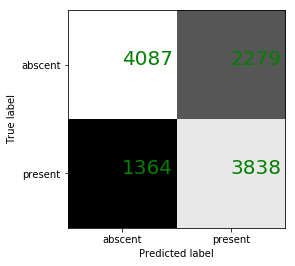

In [18]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

Since in this example we have 2 classes (labels), the confusion matrix is 2x2. Furthermore, the confusions are fairly obvious, classical can only be confused with rock, and rock can only be confused with classical. However, when working on a multiclass problem (i.e. when there are more than 2 classes), the confusion matrix can be much more informative, as it tells us how much each class is confused with every other class. This can help us identify particularly problematic classes that are confused often, and help us figure out how to improve the model: are the classes well represented by the training data or do we need more data? Are the features that we're using sufficient for distinguishing between these classes, or do we need more/different features?

### Random Forest Classifier without scaler

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators=500)

# Fit (=train) the model
clf3.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h2>Step 4: model evaluation Random Forest Classifier (testing)</h2>

Now we're going to test the model by using it to predict the class labels of the test data!

In [20]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(test_features)

<h3>Model accuracy</h3>

How well did our model perform? The simplest statistic we can compute is the "classification accuracy": in the simplest case, this is the fraction of files in our test set that were classified correctly:

In [21]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.6699515905947441


<h3>Confusion matrix</h3>

But the accuracy is only the tip of the iceberg! The model also made some mistakes - what got confused with what? To answer this we can plot the **confusion matrix**: the rows of the matrix represent the true label, and the columns represent the label predicted by the model:

In [22]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[3848 2518]
 [1300 3902]]


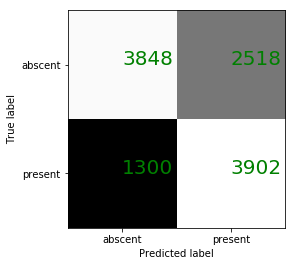

In [23]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()